In [15]:
import json
import logging
import sys
import pandas as pd
import numpy as np
import cvxportfolio as cp
import pyfolio as pf

from keras.models import load_model

from cmr.universe import build_universe
from cmr.data_loader import load_features, load_market_data, load_ret
from cmr.returns import TaReturnsForecast
from cmr.strategy import CryptoStatArb
from cmr.risk import ReturnsCovRiskModel

pd.options.plotting.backend = "plotly"

## Define scope
* time interval : 2020 Jan to 2022 Jan <br>
* crypto symbol: average daily volume over 200k USD

In [2]:
start = pd.Timestamp(2020, 1, 1)
end = pd.Timestamp(2022, 1, 30)
cfg = json.load(open("cfg/JW_CRYPTO.json"))
symbols = build_universe(cfg['symbol_pattern'], start, end, cfg['adv_limit'], cfg['resample_rule'])
display(cfg)
display(symbols)

{'portfolio_id': 'JW_CRYPTO',
 'adv_limit': 200000.0,
 'symbol_pattern': '*usd',
 'lambda_risk': 1.0,
 'half_spread': 0.005,
 'borrow_costs': 0,
 'opt_kwargs': {'leverage_limit': 1, 'max_weights': 0.1, 'min_weights': -0.1},
 'resample_rule': '1H'}

['adausd',
 'atousd',
 'bsvusd',
 'btcusd',
 'bttusd',
 'dotusd',
 'dshusd',
 'eosusd',
 'etcusd',
 'ethusd',
 'filusd',
 'ftmusd',
 'iotusd',
 'ltcusd',
 'neousd',
 'omgusd',
 'solusd',
 'trxusd',
 'udcusd',
 'uniusd',
 'uosusd',
 'ustusd',
 'xlmusd',
 'xmrusd',
 'xrpusd',
 'xtzusd',
 'yfiusd',
 'zecusd']

## Features

<i> Technical Analysis Module </i>: uses financial time series datasets (open, close, high, low, volume), for feature engineering. <br>
<i> https://technical-analysis-library-in-python.readthedocs.io/en/latest/ </i><br>
* Momentum Indicators
* Volume Indicators
* Volatility Indicators
* Trend Indicators
* Others Indicators

In [3]:
feat = load_features(symbols, start, end)
feat.tail()

ret     volume_adi     volume_obv  \
time                symbol                                           
2022-01-29 19:00:00 zecusd -0.002518  178820.752353 -143198.496723   
2022-01-29 20:00:00 zecusd  0.007994  178817.235434 -142869.735125   
2022-01-29 21:00:00 zecusd  0.007586  178896.528772 -142564.801685   
2022-01-29 22:00:00 zecusd -0.001305  178882.779683 -142668.044842   
2022-01-29 23:00:00 zecusd -0.001690  178920.279960 -142705.545120   

                            volume_cmf   volume_fi     volume_em  \
time                symbol                                         
2022-01-29 19:00:00 zecusd    0.127666   80.685309  9.158478e+04   
2022-01-29 20:00:00 zecusd    0.101926  104.852953  4.492569e+05   
2022-01-29 21:00:00 zecusd    0.115508  121.543475  2.125261e+05   
2022-01-29 22:00:00 zecusd    0.098180  102.321745  6.240414e+04   
2022-01-29 23:00:00 zecusd    0.058956   86.831132 -1.564656e+06   

                            volume_sma_em  volume_vpt  volume_vwap  \
time                symbol                                           
2022-01-29 19:00:00 zecusd -213934.846464    0.042266    94.943730   
2022-01-29 20:00:00 zecusd -184787.192539    2.396870    95.120689   
2022-01-29 21:00:00 zecusd -217281.957308    4.941178    95.246397   
2022-01-29 22:00:00 zecusd -207112.725575    2.178471    95.354407   
2022-01-29 23:00:00 zecusd -306794.837275   -0.198100    95.479943   

                            volume_mfi  ...  momentum_ppo  \
time                symbol              ...                 
2022-01-29 19:00:00 zecusd   70.278858  ...      1.290932   
2022-01-29 20:00:00 zecusd   70.103667  ...      1.289883   
2022-01-29 21:00:00 zecusd   71.921176  ...      1.335093   
2022-01-29 22:00:00 zecusd   78.400902  ...      1.344192   
2022-01-29 23:00:00 zecusd   84.613274  ...      1.321992   

                            momentum_ppo_signal  momentum_ppo_hist  \
time                symbol                                           
2022-01-29 19:00:00 zecusd             1.415449          -0.124517   
2022-01-29 20:00:00 zecusd             1.390336          -0.100453   
2022-01-29 21:00:00 zecusd             1.379287          -0.044194   
2022-01-29 22:00:00 zecusd             1.372268          -0.028076   
2022-01-29 23:00:00 zecusd             1.362213          -0.040221   

                            momentum_pvo  momentum_pvo_signal  \
time                symbol                                      
2022-01-29 19:00:00 zecusd    -12.060294            -4.558310   
2022-01-29 20:00:00 zecusd     -8.416818            -5.330012   
2022-01-29 21:00:00 zecusd     -6.249566            -5.513923   
2022-01-29 22:00:00 zecusd    -10.811862            -6.573511   
2022-01-29 23:00:00 zecusd    -17.085849            -8.675978   

                            momentum_pvo_hist  momentum_kama  others_dr  \
time                symbol                                                
2022-01-29 19:00:00 zecusd          -7.501984     125.606075  -0.251794   
2022-01-29 20:00:00 zecusd          -3.086806     125.606075   0.799361   
2022-01-29 21:00:00 zecusd          -0.735644     125.606075   0.758588   
2022-01-29 22:00:00 zecusd          -4.238351     125.606075  -0.130485   
2022-01-29 23:00:00 zecusd          -8.409871     125.606075  -0.169022   

                            others_dlr  others_cr  
time                symbol                         
2022-01-29 19:00:00 zecusd   -0.252112  -9.391023  
2022-01-29 20:00:00 zecusd    0.796183  -8.666730  
2022-01-29 21:00:00 zecusd    0.755725  -7.973887  
2022-01-29 22:00:00 zecusd   -0.130570  -8.093967  
2022-01-29 23:00:00 zecusd   -0.169165  -8.249309  

[5 rows x 85 columns]

In [4]:
feat.describe()

ret    volume_adi    volume_obv     volume_cmf     volume_fi  \
count  456939.000000  4.569460e+05  4.569460e+05  456813.000000  4.568550e+05   
mean        0.000182 -2.116887e+07  4.851989e+07       0.018530 -1.340110e+03   
std         0.015195  6.173762e+08  5.953137e+08       0.260263  5.608769e+04   
min        -0.995817 -2.905071e+10 -1.021589e+10      -2.000000 -1.436643e+07   
25%        -0.004874 -2.815053e+01 -5.210243e+06      -0.122765 -1.493601e+02   
50%         0.000000  3.321257e+05 -3.701839e+05       0.025474 -3.730201e-01   
75%         0.005169  7.241308e+06  1.756821e+05       0.169974  1.133045e+02   
max         2.636694  1.571681e+09  9.340005e+09       1.000000  2.242713e+06   

          volume_em  volume_sma_em    volume_vpt    volume_vwap  \
count  4.569380e+05   4.481330e+05  4.569460e+05  456855.000000   
mean  -6.199580e+10  -5.717104e+10 -3.474846e+04    2113.676072   
std    4.848766e+13   1.184745e+13  1.600828e+07    8693.030050   
min   -3.128465e+16  -2.120077e+15 -8.588085e+09      -0.250000   
25%   -5.542790e+01  -2.968630e+01 -2.566561e+01       0.999811   
50%    0.000000e+00   2.593424e-07  0.000000e+00       5.992001   
75%    1.066824e+02   1.467697e+02  2.873600e+01      92.220747   
max    2.715450e+15   2.602884e+14  4.976401e+08   86301.460561   

          volume_mfi  ...   momentum_ppo  momentum_ppo_signal  \
count  456855.000000  ...  456771.000000        456715.000000   
mean       49.905193  ...       0.028210             0.028893   
std        23.602011  ...       1.599894             1.491862   
min         0.000000  ...     -93.721398           -91.337471   
25%        31.851436  ...      -0.537479            -0.511588   
50%        50.043186  ...       0.004378             0.003951   
75%        67.957817  ...       0.642324             0.611821   
max       100.000000  ...      25.009295            22.276018   

       momentum_ppo_hist   momentum_pvo  momentum_pvo_signal  \
count      456715.000000  456771.000000        456715.000000   
mean           -0.000452      -6.484180            -6.482548   
std             0.455526      25.161983            19.744425   
min           -19.508829     -99.866178           -99.785167   
25%            -0.186554     -22.700689           -18.728921   
50%             0.000129      -7.764685            -6.029497   
75%             0.187207       8.551655             6.541656   
max            15.469917     107.411275            65.192875   

       momentum_pvo_hist  momentum_kama      others_dr     others_dlr  \
count      456715.000000  456883.000000  456946.000000  456939.000000   
mean           -0.000342    2400.567522       0.017195       0.006042   
std            13.952395    9965.122833       1.543763       1.701610   
min           -32.199055       0.000542     -99.581687    -547.669597   
25%            -9.094701       0.909318      -0.487400      -0.488554   
50%            -2.570073       5.300856       0.000000       0.000000   
75%             5.954096      83.731552       0.516850       0.515531   
max           164.331276   67903.432559     263.669424     129.107509   

           others_cr  
count  456946.000000  
mean      154.312576  
std       342.707634  
min       -99.853925  
25%       -25.558887  
50%        16.764305  
75%       186.656935  
max      4593.262073  

[8 rows x 85 columns]

## Data preprocessing

* Train & Test (& Validation data) split
* Feature standardization
* PCA for dimensionality reduction
* Symbol - one hot encoder
* Format to time series generators

In [5]:
rf = TaReturnsForecast(symbols, start, end)
generator_train, _, _, _ = rf.generator_train_test

In [6]:
generator_train.as_numpy_iterator().next()

(array([[[-1.1300944 , -0.33020248,  3.10558107, ..., -0.40160533,
           0.48523041,  0.07733354],
         [-1.1538943 ,  0.61303497,  3.52217949, ..., -0.27210638,
           0.11511245,  0.03545772],
         [-1.20202303,  2.61023245,  4.2734479 , ..., -0.31108775,
           0.41068103,  0.05770303]],
 
        [[-1.1538943 ,  0.61303497,  3.52217949, ..., -0.27210638,
           0.11511245,  0.03545772],
         [-1.20202303,  2.61023245,  4.2734479 , ..., -0.31108775,
           0.41068103,  0.05770303],
         [-1.21282525,  3.03799233,  3.95201861, ..., -0.57514209,
           0.0749326 , -0.08443631]],
 
        [[-1.20202303,  2.61023245,  4.2734479 , ..., -0.31108775,
           0.41068103,  0.05770303],
         [-1.21282525,  3.03799233,  3.95201861, ..., -0.57514209,
           0.0749326 , -0.08443631],
         [-1.24244589,  4.28191367,  4.15191147, ..., -0.1497064 ,
           0.16799487,  0.03434801]],
 
        ...,
 
        [[-1.21929357,  3.18526168,  3.5

## Prediction model

### Model selection
Literature on crypto currencies, mostly leveraging LSTM:
* Bitcoin Transaction Strategy Construction Based on Deep Reinforcement Learning
<i> https://arxiv.org/abs/2109.14789 </i>
* On Technical Trading and Social Media Indicators in Cryptocurrencies' Price Classification Through Deep Learning
<i> https://arxiv.org/abs/2102.08189 </i>

### Hyperparameter tuning

| Item |  |  |  |
| --- | --- | --- | --- |
| Look Back Hours| 3 | 24 | 72 |
| Batch Size | 32 | 64 | 128 |
| Loss | MSE | MAE | |
| Hidden Layers | 1 | 2 | |
| Hidden Units | 32 | 64 | |
| Hidden Activation | tanh | relu | |
| Output Activation | tanh | linear | |


Adam Optimization : dynamically adjust the learning rate of each parameter. <br>
Train / Test / Validation split. <br>
Drop out rate 0.2 <br>
Early stop with patience 2 <r>



In [7]:
# fit model (takes some time, suggest to skip this and load the fitted model)
# train_result, test_result = rf.predict()

In [8]:
# load fitted model
model = load_model('LSTM_crypto_20220220.keras')

# predict
train_result = rf.generator_train_test[2].copy()
train_result['y_train'] = model.predict(rf.generator_train_test[0])

test_result = rf.generator_train_test[3].copy()
test_result['y_pred'] = model.predict(rf.generator_train_test[1])

In [9]:
test_result.loc[(slice(None), 'btcusd'),].droplevel(1).plot()

##  Portfolio optimization and simulation

<i> cvxportfolio module </i> : portfolio optimization and simulation, based on the paper Multi-Period Trading via Convex Optimization.
<i> https://github.com/cvxgrp/cvxportfolio </i> <br>
<i> https://web.stanford.edu/~boyd/papers/cvx_portfolio.html </i> <br>

### Optimizer
* Single forecast period optimization, mean-variance portfolio optimization
* Costs : risk model, transaction cost model ( and carry cost model)
* Starts with 100k cash holding, hourly rebalance

### Constraints
* Dollar neutral
* Leverage limit 1
* Maximum holding weight 0.1
* Minimum holding weight -0.1

### Risk model
* Standard deviation risk model


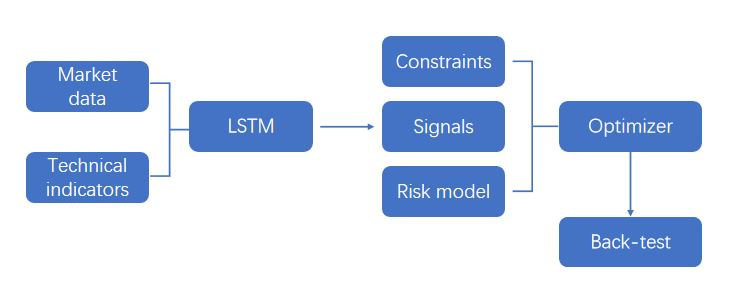

In [10]:
signals = test_result['y_pred'].unstack(level='symbol')

# build costs
risk_model = ReturnsCovRiskModel(signals.columns[:-1], start, end).get_value()
# tcost_model = cp.TcostModel(half_spread=cfg['half_spread'])  # transaction costs
# bcost_model = cp.HcostModel(borrow_costs=borrow_costs / 250)  # borrow costs
costs = [cfg['lambda_risk'] * cp.FullSigma(risk_model)]  # fit into cp format

# build strategy
optimizer = CryptoStatArb(signals, costs, **cfg['opt_kwargs'])

# back-test
returns = load_ret(signals.columns[:-1], start, end).fillna(0)
market_sim = cp.MarketSimulator(returns, [], cash_key='cash')
initial_portfolio = pd.Series(index=returns.columns, data=0)
initial_portfolio.loc['cash'] = 1e5
result = market_sim.run_backtest(initial_portfolio, signals.index[0], signals.index[-1], policy=optimizer)

In [11]:
result.v.plot()  # hourly

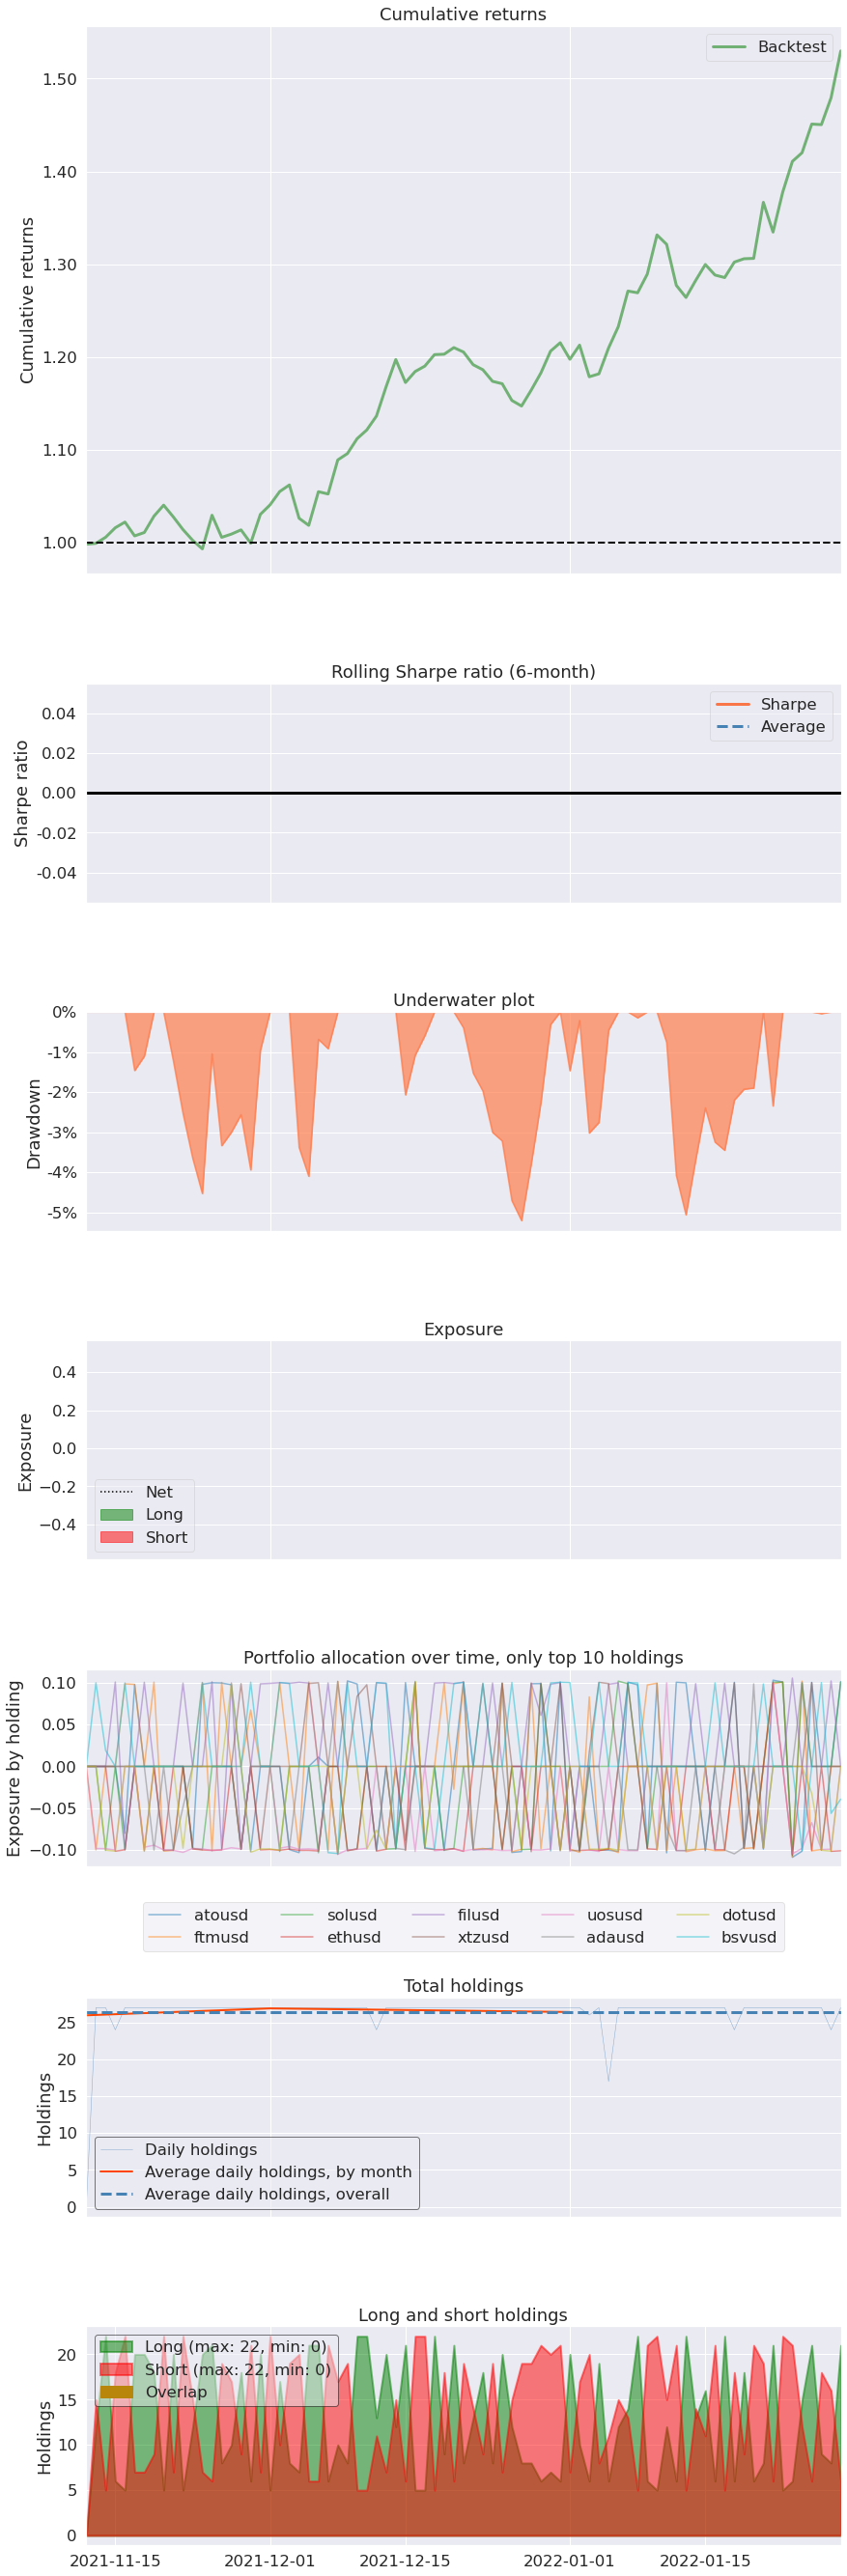

In [14]:
pd.options.plotting.backend = "matplotlib"

pf.create_simple_tear_sheet(result.returns.resample('D').sum(), result.h.resample('D').first())  # daily